In [6]:
import os, sys
import time
import json

from collections import defaultdict

import matplotlib.pyplot as plt

import bz2
import gzip
import zlib

import tempfile

In [7]:
xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost/daily/1000trees"

In [8]:
def compression_test(model_folder, compression_func, decompression_func):
    compression_ratios = defaultdict(list)
    dt_compress = defaultdict(list)
    dt_decompress = defaultdict(list)

    for model_file in os.listdir(model_folder):
        full_path = os.path.join(model_folder, model_file)
        with open(full_path, "rb") as f:
            model_binary = f.read()
        # Before Compression
        uncompressed_size = sys.getsizeof(model_binary)

        # Compress with multiple factors
        for i in range(1, 10):
            # Compress
            t0 = time.time()
            compressed_model = compression_func(model_binary, i)
            dt_compress[i].append(time.time() - t0)
            # Decompress
            t0 = time.time()
            decompressed_model = decompression_func(compressed_model)
            dt_decompress[i].append(time.time() - t0)

            assert model_binary == decompressed_model
            compressed_size = sys.getsizeof(compressed_model)
            compression_ratios[i].append(uncompressed_size / compressed_size)

    # Compute averages
    avg_compression_ratios = {}
    for key, value in compression_ratios.items():
        avg_compression_ratios[key] = sum(value) / len(value)

    avg_dt_compress = {}
    for key, value in dt_compress.items():
        avg_dt_compress[key] = sum(value) / len(value)

    avg_dt_decompress = {}
    for key, value in dt_decompress.items():
        avg_dt_decompress[key] = sum(value) / len(value)

    return avg_compression_ratios, avg_dt_compress, avg_dt_decompress

In [9]:
def compression_ratio_plot(plot_title, ylabel, gzip_ratios, zlib_ratios, bz2_ratios):
    import matplotlib.pyplot as plt

    # Example data (compression ratios at different levels for each algorithm)
    compression_levels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    bar_width = 0.25  # Width of each bar

    # Set the positions of the bars on the X-axis
    bar_positions_gzip = [i for i in range(len(compression_levels))]
    bar_positions_zlib = [i + bar_width for i in range(len(compression_levels))]
    bar_positions_bz2 = [i + 2 * bar_width for i in range(len(compression_levels))]

    # Create the figure and axis
    fig, ax = plt.subplots()

    # Plot the bars for each algorithm
    ax.bar(
        bar_positions_gzip, list(gzip_ratios.values()), width=bar_width, label="gzip"
    )
    ax.bar(
        bar_positions_zlib, list(zlib_ratios.values()), width=bar_width, label="zlib"
    )
    ax.bar(bar_positions_bz2, list(bz2_ratios.values()), width=bar_width, label="bz2")

    # Set the X-axis labels and ticks
    ax.set_xlabel("Compression Levels")
    ax.set_ylabel(ylabel)
    ax.set_title(plot_title)
    ax.set_xticks([i + bar_width for i in range(len(compression_levels))])
    ax.set_xticklabels(compression_levels)

    # Add legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
    pass

In [10]:
def compression_wrapper(model_folder):
    # GZIP
    gzip_ratios, gzip_dt_compress, gzip_dt_decompress = compression_test(
        model_folder, gzip.compress, gzip.decompress
    )
    # ZLIB
    zlib_ratios, zlib_dt_compress, zlib_dt_decompress = compression_test(
        model_folder, zlib.compress, zlib.decompress
    )
    # BZ2
    bz2_ratios, bz2_dt_compress, bz2_dt_decompress = compression_test(
        model_folder, bz2.compress, bz2.decompress
    )

    compression_ratio_plot(
        "Compression Ratios by Algorithm and Level",
        "Compression Ratio",
        gzip_ratios,
        zlib_ratios,
        bz2_ratios,
    )
    compression_ratio_plot(
        "dt_Compress by Algorithm and Level",
        "dt_Compress in Seconds",
        gzip_dt_compress,
        zlib_dt_compress,
        bz2_dt_compress,
    )
    compression_ratio_plot(
        "dt_Decompress by Algorithm and Level",
        "dt_Decompress in Seconds",
        gzip_dt_decompress,
        zlib_dt_decompress,
        bz2_dt_decompress,
    )

In [11]:
# compression_wrapper(xgboost_path)

In [12]:
import xgboost as xgb
from time import time
import math

def mean_and_std(data):
    # Calculate mean
    mean = sum(data) / len(data)

    # Calculate standard deviation
    variance = sum((x - mean) ** 2 for x in data) / len(data)
    std_dev = math.sqrt(variance)

    return mean, std_dev

In [13]:
xgboost_path = "/home/nano/projects/tree-ensemble-model-management/models/xgboost"

daily_path = xgboost_path + "/daily"
daily_100 = daily_path + "/100trees"
daily_1000 = daily_path + "/1000trees"
daily_10000 = daily_path + "/10000trees"

In [14]:
def load_model_json(model_path):
    booster = xgb.Booster()
    booster.load_model(model_path)
    return booster


def save_model_json(booster, model_path):
    booster.save_model(model_path)

In [15]:
def save_model_compressed(booster, model_path, compression_func):
    temp_model_path = tempfile.mktemp(suffix=".json")
    booster.save_model(temp_model_path)

    # Read the JSON data from the temporary file
    with open(temp_model_path, "rb") as f:
        model_binary = f.read()

    # Compress byte stream
    compressed = compression_func(model_binary)

    # Write compressed data to a file
    with open(model_path, "wb") as outfile:
        outfile.write(compressed)


def load_model_compressed(model_path, decompression_func):
    # Read and unpack the MessagePack data
    with open(model_path, "rb") as f:
        packed_data = f.read()
    model = decompression_func(packed_data)

    # Temporarily save the binary data to a file
    temp_model_path = tempfile.mktemp(suffix=".json")
    with open(temp_model_path, "wb") as f:
        f.write(model)
    # Load the model using the temporary file
    booster = xgb.Booster()
    booster.load_model(temp_model_path)
    return booster

In [39]:
def get_metrics(model_dir):
    dt_json_load = []
    dt_json_save = []
    json_sizes = []

    dt_gzip_load = []
    dt_gzip_save = []
    gzip_sizes = []

    dt_bz2_load = []
    dt_bz2_save = []
    bz2_sizes = []

    for model_file in os.listdir(model_dir):
        model_path = os.path.join(model_dir, model_file)
        # JSON
        t0 = time()
        booster = load_model_json(model_path)
        dt_json_load.append(time() - t0)
        # Save
        t0 = time()
        save_model_json(booster, model_path)
        dt_json_save.append(time() - t0)
        # Size
        json_size = os.path.getsize(model_path)
        json_sizes.append(1.0)

        # Gzip
        gzip_path = "gzip.bin"
        # Save
        t0 = time()
        save_model_compressed(booster, gzip_path, gzip.compress)
        dt_gzip_save.append(time() - t0)
        # Load
        t0 = time()
        gzip_booster = load_model_compressed(gzip_path, gzip.decompress)
        dt_gzip_load.append(time() - t0)
        # Size
        gzip_sizes.append(json_size / os.path.getsize(gzip_path))
        os.remove(gzip_path)

        # Bz2
        bz2_path = "bz2.bin"
        t0 = time()
        save_model_compressed(booster, bz2_path, bz2.compress)
        dt_bz2_save.append(time() - t0)
        # Load
        t0 = time()
        bz2_booster = load_model_compressed(bz2_path, bz2.decompress)
        dt_bz2_load.append(time() - t0)
        # Size
        bz2_sizes.append(json_size / os.path.getsize(bz2_path))
        os.remove(bz2_path)

        assert booster.get_dump() == gzip_booster.get_dump() == bz2_booster.get_dump()

    # Evaluation
    # Load
    json_mean, json_std = mean_and_std(dt_json_load)
    gzip_mean, gzip_std = mean_and_std(dt_gzip_load)
    bz2_mean, bz2_std = mean_and_std(dt_bz2_load)
    dt_load = {
        "JSON": {"mean": json_mean, "std": json_std},
        "GZIP": {"mean": gzip_mean, "std": gzip_std},
        "BZ2": {"mean": bz2_mean, "std": bz2_std},
    }
    # Save
    json_mean, json_std = mean_and_std(dt_json_save)
    gzip_mean, gzip_std = mean_and_std(dt_gzip_save)
    bz2_mean, bz2_std = mean_and_std(dt_bz2_save)
    dt_save = {
        "JSON": {"mean": json_mean, "std": json_std},
        "GZIP": {"mean": gzip_mean, "std": gzip_std},
        "BZ2": {"mean": bz2_mean, "std": bz2_std},
    }

    # Size
    json_mean, json_std = mean_and_std(json_sizes)
    gzip_mean, gzip_std = mean_and_std(gzip_sizes)
    bz2_mean, bz2_std = mean_and_std(bz2_sizes)
    sizes = {
        "JSON": {"mean": json_mean, "std": json_std},
        "GZIP": {"mean": gzip_mean, "std": gzip_std},
        "BZ2": {"mean": bz2_mean, "std": bz2_std},
    }

    return sizes, dt_save, dt_load

In [40]:
sizes_100, save_100, load_100 = get_metrics(daily_100)

In [41]:
sizes_1000, save_1000, load_1000 = get_metrics(daily_1000)

In [42]:
sizes_10000, save_10000, load_10000 = get_metrics(daily_10000)

In [43]:
import matplotlib.pyplot as plt
import numpy as np


def plot(sample1, sample2, sample3, ylabel, title):
    # Organizing the data
    means_json = [
        sample1["JSON"]["mean"],
        sample2["JSON"]["mean"],
        sample3["JSON"]["mean"],
    ]
    stds_json = [sample1["JSON"]["std"], sample2["JSON"]["std"], sample3["JSON"]["std"]]

    means_gzip = [
        sample1["GZIP"]["mean"],
        sample2["GZIP"]["mean"],
        sample3["GZIP"]["mean"],
    ]
    stds_gzip = [sample1["GZIP"]["std"], sample2["GZIP"]["std"], sample3["GZIP"]["std"]]

    means_bz2 = [
        sample1["BZ2"]["mean"],
        sample2["BZ2"]["mean"],
        sample3["BZ2"]["mean"],
    ]
    stds_bz2 = [
        sample1["BZ2"]["std"],
        sample2["BZ2"]["std"],
        sample3["BZ2"]["std"],
    ]

    # Sample labels
    labels = ["100 Trees", "1000 Trees", "10000 Trees"]

    # Setting the positions of the bars
    x = np.arange(len(labels))  # the sample locations
    width = 0.2  # the width of the bars

    # Creating the plot
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, means_json, width, yerr=stds_json, label="json")
    rects2 = ax.bar(x, means_gzip, width, yerr=stds_gzip, label="gzip")
    rects3 = ax.bar(x + width, means_bz2, width, yerr=stds_bz2, label="bz2")

    # Adding some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Function to attach a text label above each bar
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    # Attaching the labels
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    # Showing the plot
    plt.tight_layout()
    plt.show()

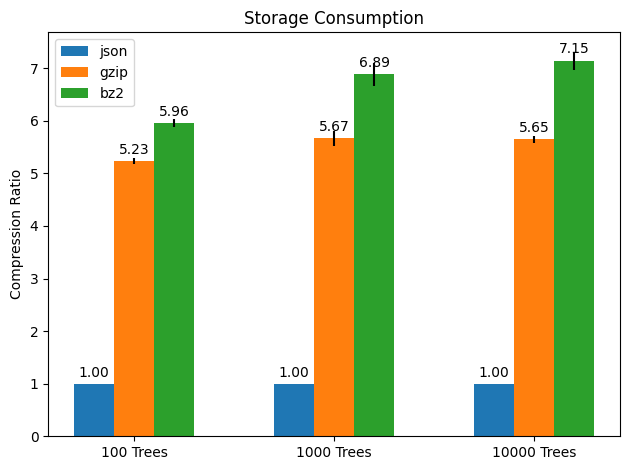

In [44]:
plot(sizes_100, sizes_1000, sizes_10000, ylabel="Compression Ratio", title="Storage Consumption")

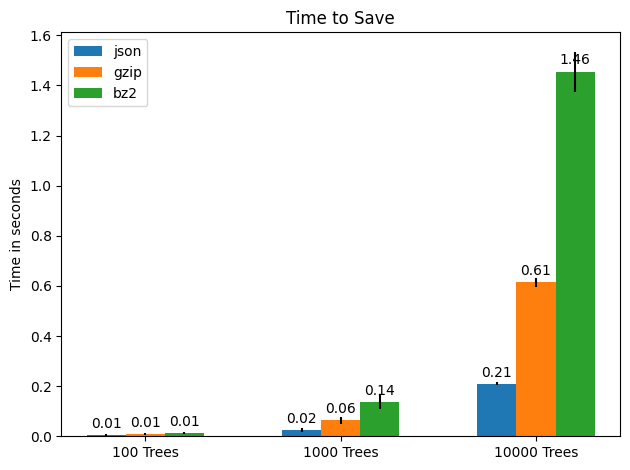

In [45]:
plot(save_100, save_1000, save_10000, ylabel="Time in seconds", title="Time to Save")

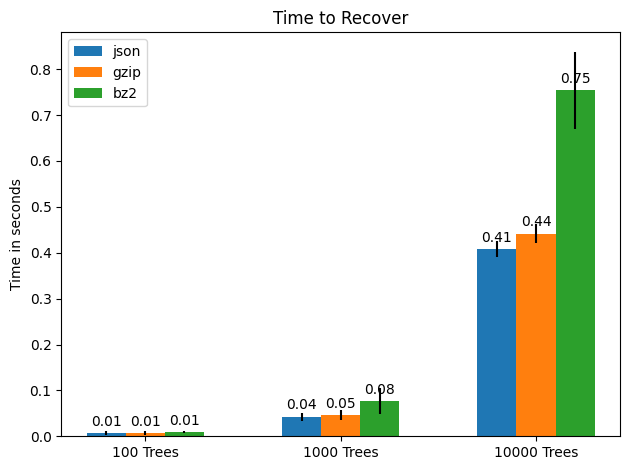

In [46]:
plot(load_100, load_1000, load_10000, ylabel="Time in seconds", title="Time to Recover")